<a href="https://colab.research.google.com/github/ruizleandro/Credit-Card-Fraud-Detection/blob/master/Model_Development_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preface

### Libraries Installation

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Getting the Data

[Link to dataset's Kaggle page](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving credit_card_fraud_detection.csv to credit_card_fraud_detection.csv
User uploaded file "credit_card_fraud_detection.csv" with length 150828752 bytes


In [4]:
df = pd.read_csv('credit_card_fraud_detection.csv')

# Model Selection

## Data Scaling and Splitting

In [5]:
x_data = df.copy().drop(['Class'], axis=1)
y_data = df['Class'].copy()

In [6]:
from sklearn.preprocessing import StandardScaler
featuresToScale = x_data.columns
scaler = StandardScaler(copy=True)
x_data.loc[:,featuresToScale] = scaler.fit_transform(x_data[featuresToScale])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.33,
                                                    random_state=2018,
                                                    stratify=y_data)

## Functions Build

Creating a function to recreate the reconstruction loss scores:

In [ ]:
def reconstructionScores(original_df, inversed_df):
  loss = np.sum((np.array(original_df) - np.array(inversed_df)) ** 2, axis=1)
  loss = pd.Series(data=loss, index=original_df.index) # creating an array
  loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
  return loss

Function that plots a scatter plot with the labels 

In [ ]:
def scatterPlot(data_x, data_y, algorithm_name):
  df_plot = pd.DataFrame(data=data_x.loc[:,0:1], index=data_x.index)
  df_plot = pd.concat((df_plot, data_y), axis=1, join='inner')
  df_plot.columns = ['1st vector', '2nd vector', 'Label']
  sns.lmplot(x='1st vector', y='2nd vector', hue='Label',
             data=df_plot, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using " + algorithm_name)

Creating a function that plots the Precision-Recall Curve and the Area Under Receiver Operating Characteristics Curve (AUROC Curve):

In [ ]:
# evaluation metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

## Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

n_components = 27
whiten = False

pca = PCA(n_components=n_components, whiten=whiten, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_inverse = pca.inverse_transform(X_train_pca)
X_train_inverse = pd.DataFrame(data=X_train_inverse, index=X_train.index)

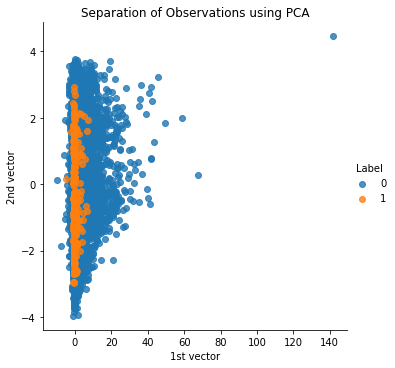

In [ ]:
scatterPlot(X_train_pca, y_train, 'PCA')

### Precision-Recall and auROC Curve

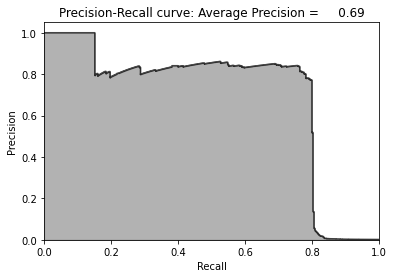

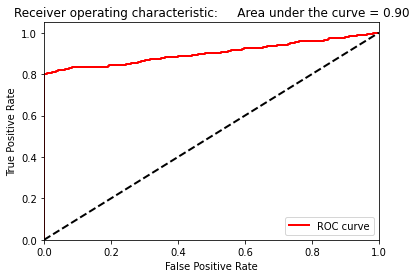

In [ ]:
anomaly_scores_pca = reconstructionScores(X_train, X_train_inverse)
preds = plotResults(y_train, anomaly_scores_pca, True)

### PCA on test set

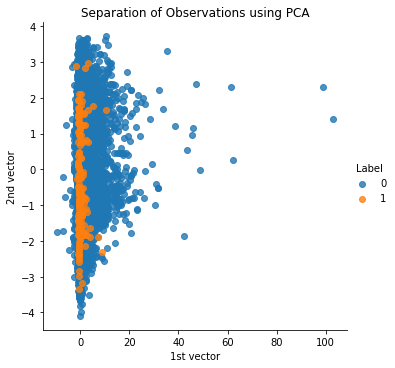

In [ ]:
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, index=X_test.index)

scatterPlot(X_test_PCA, y_test, 'PCA')

#### Precision-Recall and auROC Curve

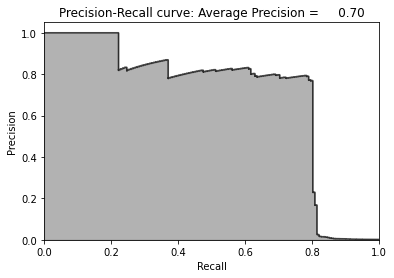

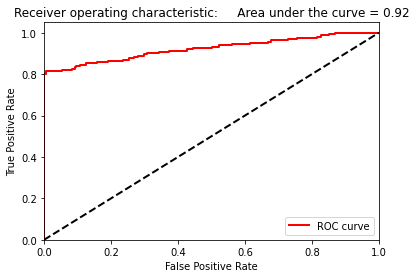

In [ ]:
anomaly_scores_pca = reconstructionScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomaly_scores_pca, True)

## Independent Component Analysis

Explica las principales diferencias entre ICA y PCA.

In [ ]:
from sklearn.decomposition import FastICA

fastICA = FastICA(n_components=27, algorithm='parallel', whiten=True,
                  max_iter=200, random_state=42)

X_train_ica = fastICA.fit_transform(X_train)
X_train_ica = pd.DataFrame(data=X_train_ica, index=X_train.index)

X_train_ica_inverse = fastICA.inverse_transform(X_train_ica)
X_train_ica_inverse = pd.DataFrame(data=X_train_ica_inverse,
                                   index=X_train.index)

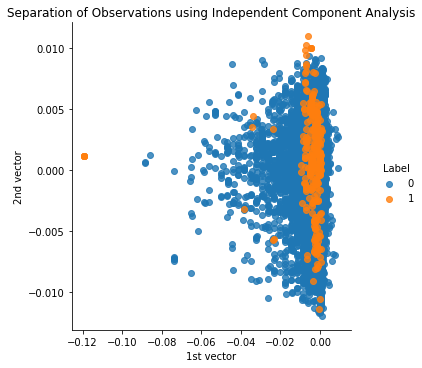

In [ ]:
scatterPlot(X_train_ica, y_train, 'Independent Component Analysis')

#### Precision-Recall and auROC Curve

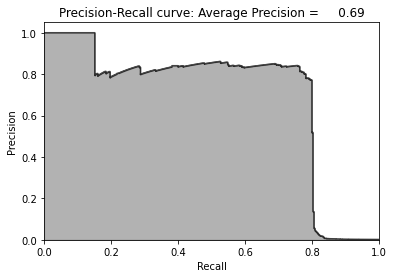

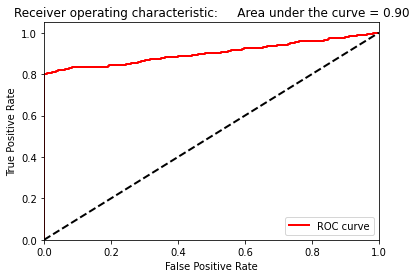

In [ ]:
anomaly_scores_ica = reconstructionScores(X_train, X_train_ica_inverse)
preds = plotResults(y_train, anomaly_scores_ica, True)

### ICA on the test set

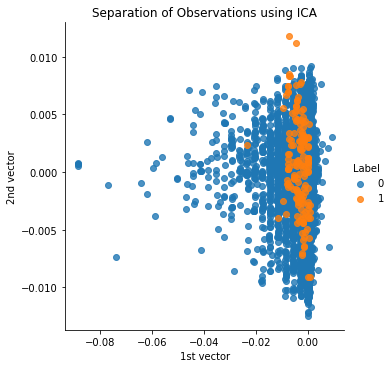

In [ ]:
X_test_ICA = fastICA.transform(X_test)
X_test_ICA = pd.DataFrame(data=X_test_ICA, index=X_test.index)

X_test_ICA_inverse = pca.inverse_transform(X_test_ICA)
X_test_ICA_inverse = pd.DataFrame(data=X_test_ICA_inverse, index=X_test.index)

scatterPlot(X_test_ICA, y_test, 'ICA')

#### Precision-Recall and auROC Curve

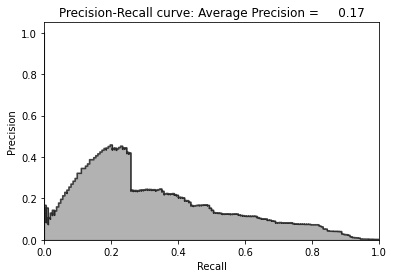

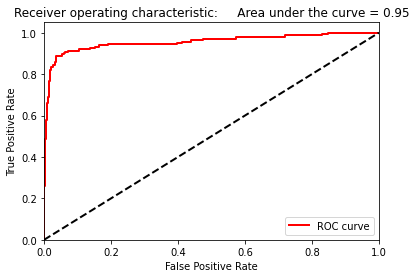

In [ ]:
anomaly_scores_ica = reconstructionScores(X_test, X_test_ICA_inverse)
preds = plotResults(y_test, anomaly_scores_ica, True)

## One-Class SVM

Voy a hacer una busqueda de hiperparametros usando mini-sets de entrenamiento. Luego, entrenare el que de mejores resultados con un train set completo y su prueba final con el test set.

In [ ]:
Fraud = df[df['Class']==1].reset_index(drop=True)
Not_fraud = df[df['Class']==0].reset_index(drop=True)

x_normal = Not_fraud.drop('Class', 1)
x_abnormal = Fraud.drop('Class', 1)

In [ ]:
'''
Simple Grid Search (from the book Introduction to Machine Learning with Python)
'''
from sklearn.svm import OneClassSVM
from sklearn.metrics import average_precision_score

X_train_sample = x_normal.loc[0:32000, :]
X_val = x_normal.loc[32000:39000, :].append(x_abnormal.loc[0:110, :])
y_val = Not_fraud.loc[32000:39000, 'Class'].append(Fraud.loc[0:110, 'Class'])

print("Size of training set: {}\nSize of test set: {}".format(
    X_train_sample.shape[0], X_val.shape[0]))

best_score = 0

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
  for nu in [0.20, 0.40, 0.60, 0.80]:
    # for each combination of parameters, train a model
    clf = OneClassSVM(kernel=kernel, nu=nu)
    clf.fit(X_train_sample)
    # evaluate the model on the test set
    y_pred = clf.predict(X_val)
    score = average_precision_score(y_val, y_pred)
    # if we got a better score, store the score and parameters
    if score > best_score:
      best_score = score
      best_params = {'kernel': kernel, 'nu': nu}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_params))

Size of training set: 32001
Size of test set: 7112
Best score: 0.82
Best parameters: {'kernel': 'rbf', 'nu': 0.2}


### One-Class SVM on the test set

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import average_precision_score

clf = OneClassSVM(kernel = 'rbf', nu = 0.2)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.2, shrinking=True, tol=0.001, verbose=False)

In [10]:
clf_pred = clf.predict(X_test)

#### Confusion Matrix

> -1: Inliers

> +1: Outliers

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf_pred)

array([[    0,     0,     0],
       [18495,     0, 75330],
       [  152,     0,    10]])

#### Classification Report

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00     93825
           1       0.00      0.06      0.00       162

    accuracy                           0.00     93987
   macro avg       0.00      0.02      0.00     93987
weighted avg       0.00      0.00      0.00     93987



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf_pred)

0.1294253486100009

#### Precision-Recall Curve

In [14]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, clf_pred)

print('Precision:', precision)
print('Recall:', recall)
print('Thresholds:', thresholds)

Precision: [1.72364263e-03 1.32731617e-04 1.00000000e+00]
Recall: [1.        0.0617284 0.       ]
Thresholds: [-1  1]


#### Precision-Recall Score

In [15]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, clf_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.00


# Future Work

To continue this project, I could fine-tune the hyperparameters of the most promising models (I could not do this myself, because it would take too long to do a complete search for the best parameters). Also, I could try new models of unsupervised learning.